# Model Evaluation and Analysis
This notebook loads predictions from all models (SARIMA, SIR, SEIR) and visualizes their performance.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure figure size
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

In [22]:
# Define paths
pred_dir = Path('../predictions')

# Load predictions
models = {}

# SARIMA
sarima_path = pred_dir / 'sarima_predictions.csv'
if sarima_path.exists():
    models['SARIMA'] = pd.read_csv(sarima_path)
    models['SARIMA']['date'] = pd.to_datetime(models['SARIMA']['date'])
    print(f"Loaded SARIMA predictions: {len(models['SARIMA'])} rows")
else:
    print(f"Warning: {sarima_path} not found")

# SIR
sir_path = pred_dir / 'sir_predictions.csv'
if sir_path.exists():
    models['SIR'] = pd.read_csv(sir_path)
    models['SIR']['date'] = pd.to_datetime(models['SIR']['date'])
    print(f"Loaded SIR predictions: {len(models['SIR'])} rows")
else:
    print(f"Warning: {sir_path} not found")

# SEIR
seir_path = pred_dir / 'seir_predictions.csv'
if seir_path.exists():
    models['SEIR'] = pd.read_csv(seir_path)
    models['SEIR']['date'] = pd.to_datetime(models['SEIR']['date'])
    print(f"Loaded SEIR predictions: {len(models['SEIR'])} rows")
else:
    print(f"Warning: {seir_path} not found")

print(f"\nTotal models loaded: {len(models)}")

Loaded SARIMA predictions: 319 rows
Loaded SIR predictions: 103 rows
Loaded SEIR predictions: 103 rows

Total models loaded: 3


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }

# Calculate metrics for each model and region
regions = ['nat']
metrics_summary = []

for model_name, df in models.items():
    for region in regions:
        region_data = df[df['region'] == region]
        if len(region_data) > 0:
            metrics = calculate_metrics(
                region_data['true_ili'].values,
                region_data['predicted_ili'].values
            )
            metrics_summary.append({
                'Model': model_name,
                'Region': region,
                **metrics
            })

metrics_df = pd.DataFrame(metrics_summary)
print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))


Metrics Summary:
 Model Region     RMSE      MAE      MAPE        R2
SARIMA    nat 1.393798 0.996413 33.163045  0.299754
   SIR    nat 1.971742 1.695968 57.575031 -0.401366
  SEIR    nat 1.942235 1.669883 56.671333 -0.359736


### Regional PRedictions

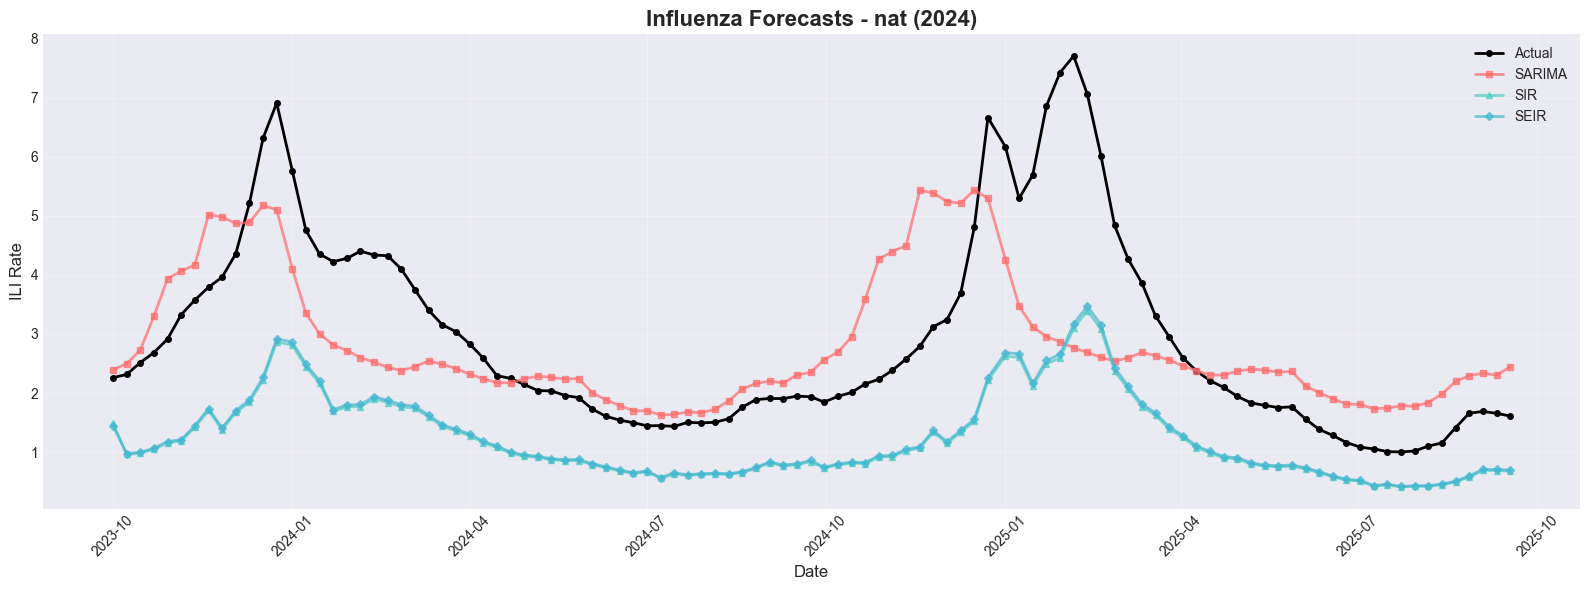

Plot saved: predictions/predictions_nat.png


In [24]:
# Plot predictions for each region
for region in regions:
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Get actual values (from first available model)
    first_model = list(models.keys())[0]
    region_data = models[first_model][models[first_model]['region'] == region]
    
    if len(region_data) > 0:
        # Plot actual values
        ax.plot(region_data['date'], region_data['true_ili'], 
                'k-', linewidth=2, label='Actual', marker='o', markersize=4)
        
        # Plot predictions from each model
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        markers = ['s', '^', 'D']
        
        for idx, (model_name, df) in enumerate(models.items()):
            model_region_data = df[df['region'] == region]
            if len(model_region_data) > 0:
                ax.plot(model_region_data['date'], model_region_data['predicted_ili'],
                        linewidth=2, label=model_name, alpha=0.7,
                        marker=markers[idx % len(markers)], markersize=4,
                        color=colors[idx % len(colors)])
        
        ax.set_title(f'Influenza Forecasts - {region} (2024)', fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('ILI Rate', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        # Format x-axis
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save plot
        plt.savefig(f'../predictions/predictions_{region}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Plot saved: predictions/predictions_{region}.png")
    else:
        print(f"No data available for region: {region}")

In [25]:
# Load CV results
cv_models = {}

# SARIMA CV
sarima_cv_path = pred_dir / 'sarima_cv_results.csv'
if sarima_cv_path.exists():
    cv_models['SARIMA'] = pd.read_csv(sarima_cv_path)
    print(f"Loaded SARIMA CV results: {len(cv_models['SARIMA'])} folds")
else:
    print(f"Warning: {sarima_cv_path} not found")

# SIR CV
sir_cv_path = pred_dir / 'sir_cv_results.csv'
if sir_cv_path.exists():
    cv_models['SIR'] = pd.read_csv(sir_cv_path)
    print(f"Loaded SIR CV results: {len(cv_models['SIR'])} folds")
else:
    print(f"Warning: {sir_cv_path} not found")

# SEIR CV
seir_cv_path = pred_dir / 'seir_cv_results.csv'
if seir_cv_path.exists():
    cv_models['SEIR'] = pd.read_csv(seir_cv_path)
    print(f"Loaded SEIR CV results: {len(cv_models['SEIR'])} folds")
else:
    print(f"Warning: {seir_cv_path} not found")

print(f"\nTotal CV models loaded: {len(cv_models)}")

Loaded SARIMA CV results: 20 folds
Loaded SIR CV results: 5 folds
Loaded SEIR CV results: 5 folds

Total CV models loaded: 3


In [26]:
# Filter for 'nat' region and calculate average metrics across folds
cv_metrics_summary = []

for model_name, cv_df in cv_models.items():
    # Filter for national data
    nat_data = cv_df[cv_df['region'] == 'nat']
    
    if len(nat_data) > 0:
        cv_metrics_summary.append({
            'Model': model_name,
            'RMSE': nat_data['rmse'].mean(),
            'MAE': nat_data['mae'].mean(),
            'MAPE': nat_data['mape'].mean(),
            'R²': nat_data['r2'].mean(),
            'Peak Week Error': nat_data['peak_week_error'].abs().mean()
        })

cv_metrics_df = pd.DataFrame(cv_metrics_summary)
print("Cross-Validation Metrics (National, averaged across folds):")
print(cv_metrics_df.to_string(index=False))

Cross-Validation Metrics (National, averaged across folds):
 Model     RMSE      MAE       MAPE         R²  Peak Week Error
SARIMA 2.188502 1.924880 103.861583 -28.513005              4.8
   SIR 2.891552 2.270387 160.273378 -11.244582             29.4
  SEIR 2.029620 1.757205  72.410798  -8.865924              5.6


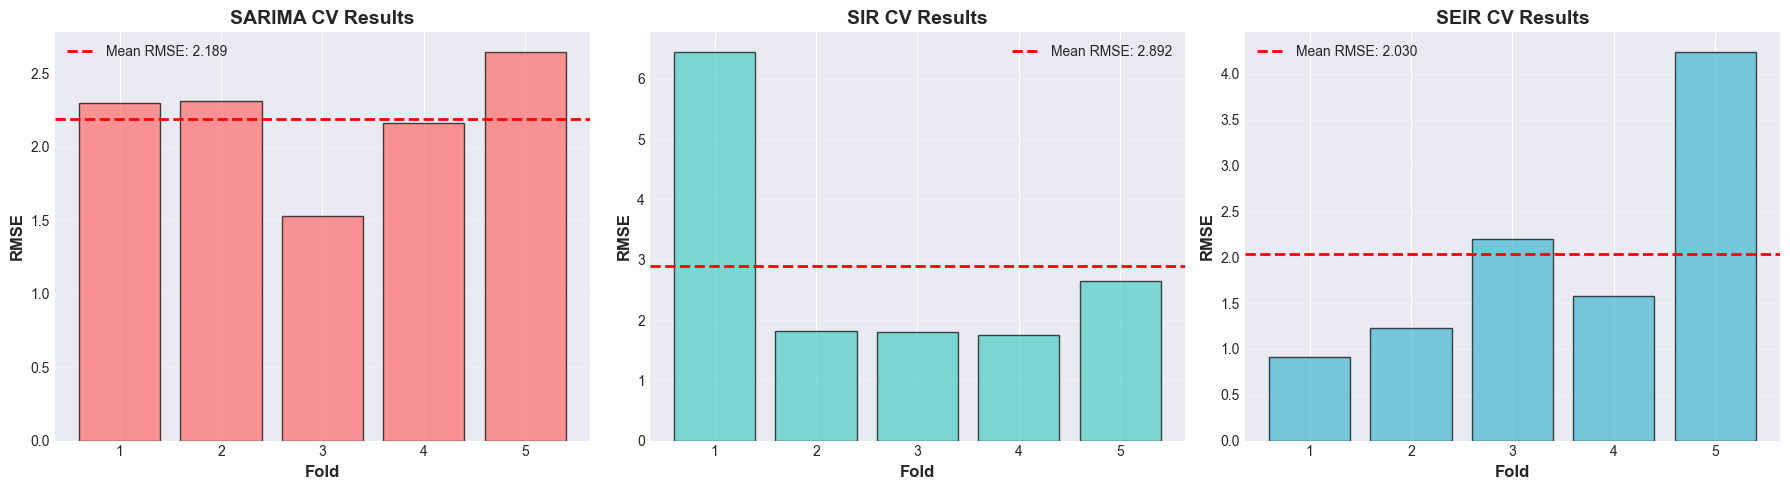

\nSaved: predictions/cv_results_comparison.png


In [27]:
# Create 1x3 subplot visualizing CV results for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_names = ['SARIMA', 'SIR', 'SEIR']
colors_map = {'SARIMA': '#FF6B6B', 'SIR': '#4ECDC4', 'SEIR': '#45B7D1'}

for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    
    if model_name in cv_models:
        cv_df = cv_models[model_name]
        nat_data = cv_df[cv_df['region'] == 'nat']
        
        if len(nat_data) > 0:
            # Plot metrics as bars for each fold
            folds = nat_data['fold'].values
            rmse_vals = nat_data['rmse'].values
            
            # Create bar plot
            bars = ax.bar(folds, rmse_vals, color=colors_map[model_name], alpha=0.7, edgecolor='black')
            
            # Add mean line
            mean_rmse = rmse_vals.mean()
            ax.axhline(y=mean_rmse, color='red', linestyle='--', linewidth=2, 
                      label=f'Mean RMSE: {mean_rmse:.3f}')
            
            ax.set_xlabel('Fold', fontsize=12, fontweight='bold')
            ax.set_ylabel('RMSE', fontsize=12, fontweight='bold')
            ax.set_title(f'{model_name} CV Results', fontsize=14, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3, axis='y')
            
            # Set xticks to show fold numbers
            ax.set_xticks(folds)
        else:
            ax.text(0.5, 0.5, f'No national data for {model_name}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{model_name} CV Results', fontsize=14, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f'{model_name} data not loaded', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{model_name} CV Results', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../predictions/cv_results_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\\nSaved: predictions/cv_results_comparison.png")

In [ ]:
# Calculate peak analysis and comprehensive metrics table (TEST SET METRICS)
comprehensive_metrics = []

for model_name in ['SARIMA', 'SIR', 'SEIR']:
    metrics_dict = {'Model': model_name}
    
    # Get TEST SET predictions and calculate metrics
    if model_name in models:
        model_df = models[model_name]
        nat_pred = model_df[model_df['region'] == 'nat']
        
        if len(nat_pred) > 0:
            # Calculate test set metrics using the same function as cell 3
            test_metrics = calculate_metrics(
                nat_pred['true_ili'].values,
                nat_pred['predicted_ili'].values
            )
            metrics_dict['RMSE'] = test_metrics['RMSE']
            metrics_dict['MAE'] = test_metrics['MAE']
            metrics_dict['MAPE'] = test_metrics['MAPE']
            metrics_dict['R²'] = test_metrics['R2']
            
            # Peak analysis
            actual_peak_value = nat_pred['true_ili'].max()
            actual_peak_idx = nat_pred['true_ili'].idxmax()
            pred_peak_value = nat_pred.loc[actual_peak_idx, 'predicted_ili']
            pct_diff_at_peak = ((pred_peak_value - actual_peak_value) / actual_peak_value) * 100
            
            metrics_dict['Actual Peak'] = actual_peak_value
            metrics_dict['Predicted Peak'] = pred_peak_value
            metrics_dict['% Diff at Peak'] = pct_diff_at_peak
    
    comprehensive_metrics.append(metrics_dict)

# Create DataFrame
comprehensive_df = pd.DataFrame(comprehensive_metrics)

# Display table with formatting
print("\n" + "="*100)
print("COMPREHENSIVE MODEL EVALUATION METRICS (National Region - Test Set)")
print("="*100)
print()
print(comprehensive_df.to_string(index=False))
print()
print("="*100)
print("Notes:")
print("- All metrics are calculated on the test set predictions (2023-10-01 to 2025-09-17)")
print("- Peak analysis is based on the actual peak timepoint in the test data")
print("- % Diff at Peak: Positive = overprediction, Negative = underprediction")
print("="*100)

In [ ]:
# Create a formatted table suitable for publication/reports
styled_metrics = comprehensive_df.copy()

# Format numeric columns
if 'RMSE' in styled_metrics.columns:
    styled_metrics['RMSE'] = styled_metrics['RMSE'].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')
if 'MAE' in styled_metrics.columns:
    styled_metrics['MAE'] = styled_metrics['MAE'].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')
if 'MAPE' in styled_metrics.columns:
    styled_metrics['MAPE'] = styled_metrics['MAPE'].apply(lambda x: f'{x:.2f}%' if pd.notna(x) else 'N/A')
if 'R²' in styled_metrics.columns:
    styled_metrics['R²'] = styled_metrics['R²'].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')
if 'Actual Peak' in styled_metrics.columns:
    styled_metrics['Actual Peak'] = styled_metrics['Actual Peak'].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')
if 'Predicted Peak' in styled_metrics.columns:
    styled_metrics['Predicted Peak'] = styled_metrics['Predicted Peak'].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A')
if '% Diff at Peak' in styled_metrics.columns:
    styled_metrics['% Diff at Peak'] = styled_metrics['% Diff at Peak'].apply(
        lambda x: f'{x:+.2f}%' if pd.notna(x) else 'N/A'
    )

print("\n" + "="*120)
print(" " * 35 + "FORMATTED METRICS TABLE (TEST SET)")
print("="*120)
print(styled_metrics.to_string(index=False))
print("="*120)
print("Notes:")
print("- These are TEST SET metrics, not cross-validation metrics")
print("- Test set period: 2023-10-01 to 2025-09-17")
print("- For CV metrics, see Cell 7 above")
print("="*120)